In [353]:
import pandas as pd
import pyodbc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SQL servers credentials
live_samo = 'Driver={SQL Server};''Server=pck-sam-sql-04;''Database=TUI;''Trusted_Connection=yes;'
archive_samo = 'Driver={SQL Server};''Server=pvm-sam-sql-05.tui.local;''Database=TUI;''Trusted_Connection=yes;'
analytics = 'Driver={SQL Server};''Server=pvm-bi-sql-01;''Database=TUIOlap;''Trusted_Connection=yes;'

# function to pull data from sql table
def sql_pull(cred, sql_query):
    conn = pyodbc.connect(cred)
    cursor = conn.cursor()
    result = pd.read_sql_query(sql_query,conn)

    cursor.close()
    del cursor
    conn.close()
    
    return result

# function to pull data from sql
def dos_report():
    return sql_pull(live_samo, ' \
                SELECT claim.datebeg AS \'CHECK-IN\', \
                       tour.lname AS \'TOUR\', \
                       hotel.lname AS \'HOTEL\', \
                       region.lname AS \'HOTEL_REGION\', \
                       partner.lname AS \'DMC\', \
                       pax.adult + pax.child AS \'PAX\', \
                       DATEDIFF(DAY, claim.cdatetime, claim.datebeg) AS \'DOS\' \
                FROM claim \
                LEFT JOIN tour \
                    ON claim.tour = tour.inc \
                LEFT JOIN v_claimPax pax \
                    ON claim.inc = pax.inc \
                LEFT JOIN state \
                    ON tour.state = state.inc \
                LEFT JOIN [order] res \
                    ON claim.inc = res.claim \
                LEFT JOIN hotel \
                    ON res.hotel = hotel.inc \
                LEFT JOIN town \
                    ON hotel.town = town.inc \
                LEFT JOIN region \
                    ON town.region = region.inc \
                LEFT JOIN partner \
                    ON res.partner = partner.inc \
                WHERE state.lname = \'UAE\' \
                      AND claim.datebeg >= \'2019-01-01 00:00:00\' \
                      AND res.hotel >= 0 ')

# saving data into df
data = dos_report()

# data cleaning
data = data[data.DOS >= 0]
data['YEAR'] = data['CHECK-IN'].dt.strftime('%Y')

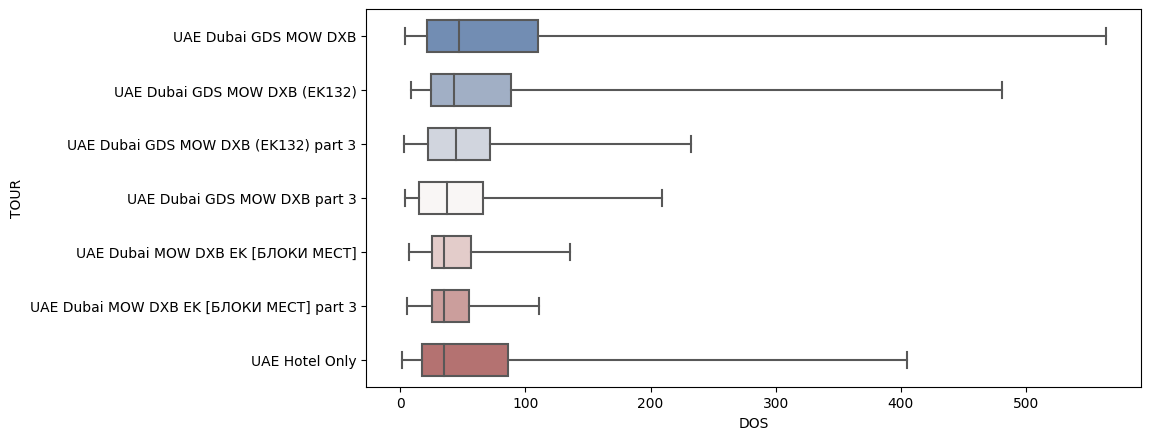

In [147]:
test2 = data.groupby(['TOUR','CHECK-IN']).agg(DOS=('DOS', 'mean'), PAX=('PAX','sum')).reset_index()
test2

plt.figure(figsize = (10,5), dpi = 100)
sns.boxplot(y='TOUR',
            x='DOS',
            data=test2[test2.TOUR.isin(t)],
            whis=[0, 100], width=.6, palette="vlag")

plt.show()

In [362]:
# eb - early booking
# ms - main sales
# lt - late trading

first = (data.DOS.describe()[4] + 1).astype(int)
second = (data.DOS.describe()[5] + 1).astype(int)
third = (data.DOS.describe()[6] + 1).astype(int)

lt = range(0, first)
ms = range(first, second)
eb = range(second, third)

data['DOS_TYPE'] = 'Deep Space'

data.loc[data.DOS.isin(eb), 'DOS_TYPE'] = 'Early Booking'
data.loc[data.DOS.isin(ms), 'DOS_TYPE'] = 'Main Sells'
data.loc[data.DOS.isin(lt), 'DOS_TYPE'] = 'Late Trading'

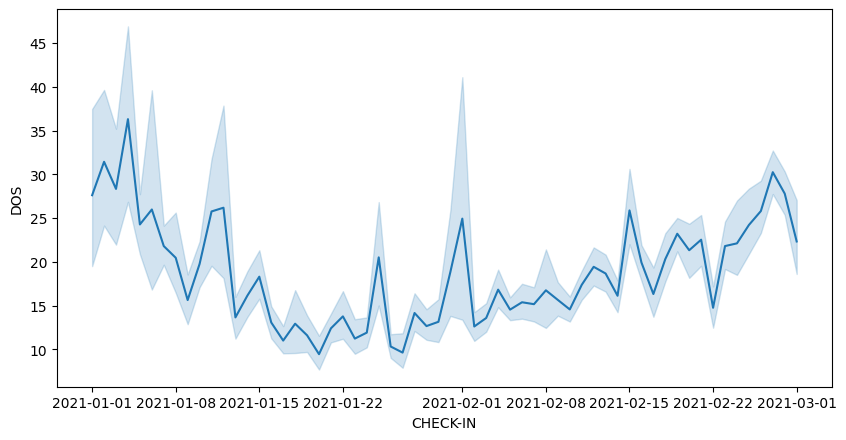

In [372]:
plt.figure(figsize = (10,5), dpi = 100)

graph_data = data[(data['CHECK-IN'] >= '2021-01-01')&(data['CHECK-IN'] <= '2021-03-01')]


sns.lineplot(data =  graph_data, 
                x = 'CHECK-IN', 
                y = 'DOS')

plt.show()

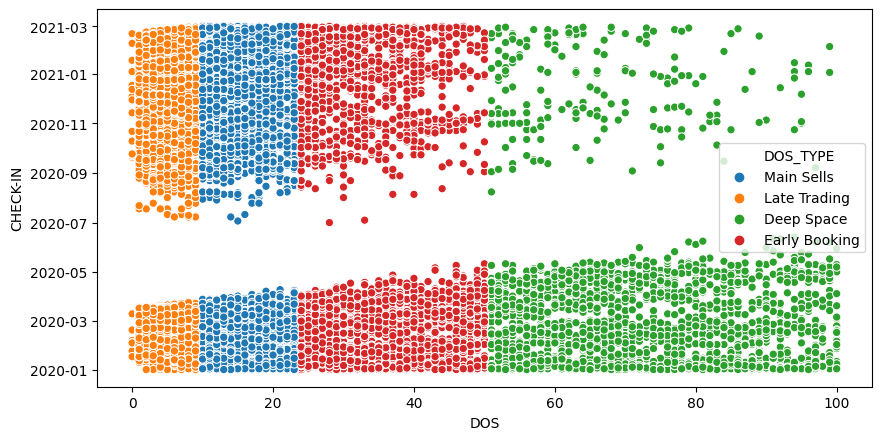

In [374]:
plt.figure(figsize = (10,5), dpi = 100)

graph_data = data[(data['CHECK-IN'] >= '2020-01-01')&(data['CHECK-IN'] <= '2021-03-01')]


sns.scatterplot(data =  graph_data, 
                y = 'CHECK-IN', 
                x = graph_data[graph_data.DOS <= 100].DOS, 
                hue = 'DOS_TYPE')

plt.show()